# Making a Synth - Oscillators

### Lazy Iteration

In [1]:
import time

# Function that processes values.
def some_function(value):
    time.sleep(1)
    return value * 2

In [2]:
# A generator expression
processed_values_gen = (some_function(i) for i in range(30))

In [3]:
next(processed_values_gen)

0

In [4]:
def generator_function():
    for i in range(30):
        yield some_function(i)

In [5]:
processed_values_gen = generator_function()
next(processed_values_gen)

0

### Synthesizer

## Bare Bones, just a simple sine.

In [6]:
import math
import librosa
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
SR = 44_100 # Sample rate

In [7]:
figsize=(25, 6.25)
colors = "#323031", "#308E91", "#34369D","#5E2A7E", "#5E2A7E", "#6F3384"

In [8]:
def plot(xy, r=1,c=1,i=1,title="", xlabel="",ylabel="",yticks=None, xticks=None,**plot_kwargs):
    plt.subplot(r,c,i)
    plt.title(title)
    if len(xy) == 2:
        plt.plot(*xy, **plot_kwargs)
    else:
        plt.plot(xy, **plot_kwargs)
        
    if xticks is not None: plt.xticks(xticks)
    if yticks is not None: plt.yticks(yticks)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [9]:
def get_sin_oscillator(freq=1, sample_rate=512):
    increment = (2 * math.pi * freq)/ sample_rate
    return (math.sin(v) for v in itertools.count(start=0, step=increment))

In [10]:
def get_n(iterator, n):
    return [next(iterator)for i in range(n)]

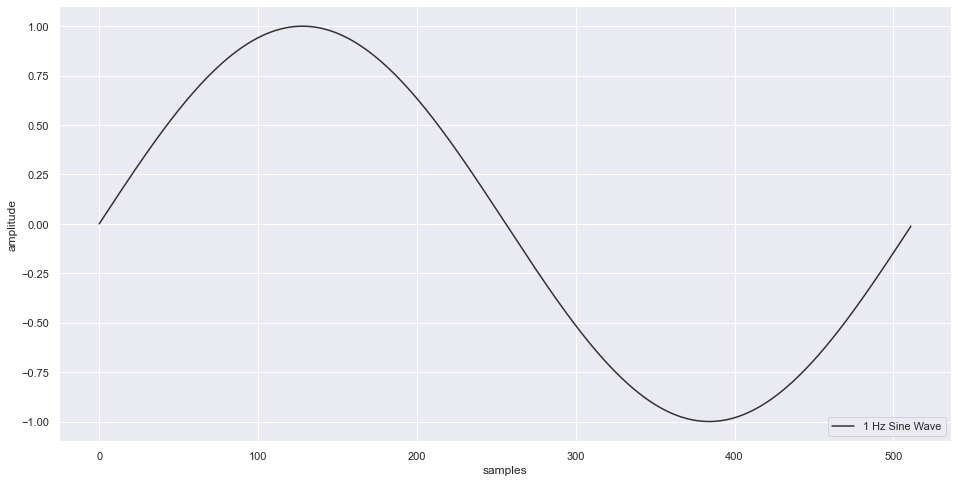

In [11]:
# List comprehension to generate 512 samples.
fig = plt.figure(figsize=(8*2,4*2))

hz = 1
osc = get_sin_oscillator(freq=hz, sample_rate=512); 
wave = get_n(osc, 512)
plot(wave, label=f"{hz} Hz Sine Wave", xlabel="samples", ylabel="amplitude", color=colors[0])

plt.legend(loc='lower right')
plt.show()
fig.savefig("sine.jpg")

## Oscillator parameters

In [12]:
def get_sin_oscillator(freq=1, sample_rate=512, amp=1, phase=0):
    phase = (phase / 360) * 2 * math.pi
    increment = (2 * math.pi * freq)/ sample_rate
    return (math.sin(phase + v)*amp for v in itertools.count(start=0, step=increment))

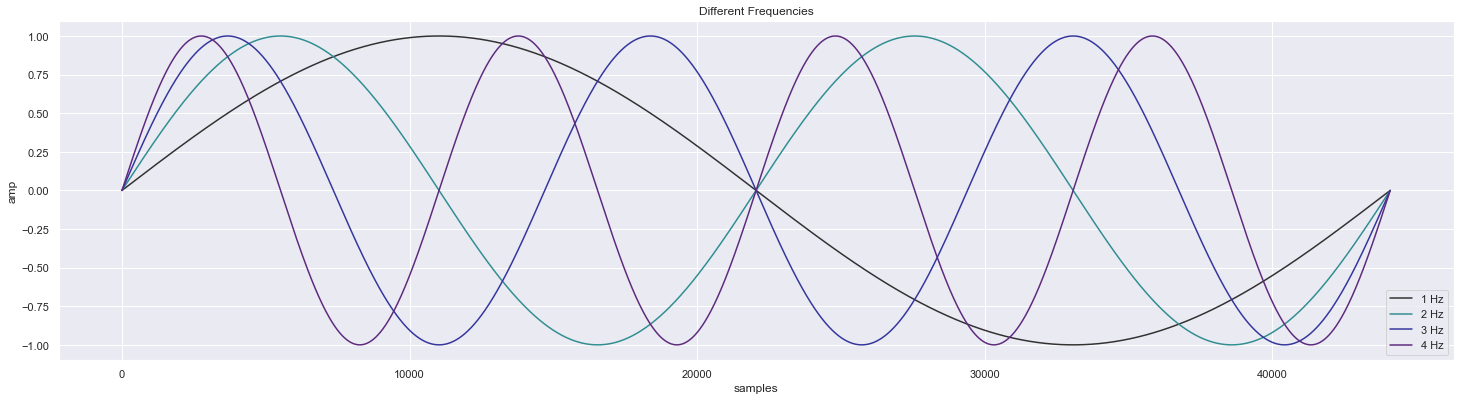

In [13]:
# List comprehension to generate 512 samples.
fig = plt.figure(figsize=figsize)
plt.title("Different Frequencies")

for hz,c in zip([1,2,3,4],colors):
    osc = get_sin_oscillator(freq=hz, sample_rate=SR); 
    wave = get_n(osc, SR)
    plt.plot(wave, label=f"{hz} Hz", color=c)

plt.ylabel("amp")
plt.xlabel("samples")
plt.legend(loc='lower right')
plt.show()

fig.savefig("sine_freq.jpg")

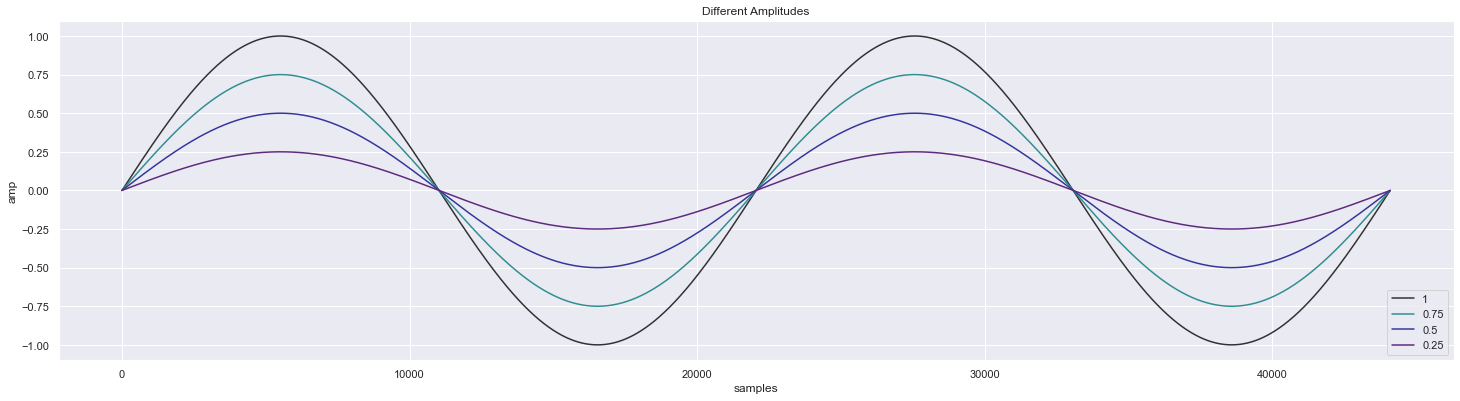

In [14]:
# List comprehension to generate 512 samples.
fig = plt.figure(figsize=figsize)
plt.title("Different Amplitudes")

for amp,c in zip([1,0.75,0.5,0.25], colors):
    osc = get_sin_oscillator(freq=2, sample_rate=SR, amp=amp); 
    wave = get_n(osc, SR)
    plt.plot(wave, label=f"{amp}", color=c)

plt.ylabel("amp")
plt.xlabel("samples")
plt.legend(loc='lower right')
plt.show()
fig.savefig("sine_amp.jpg")

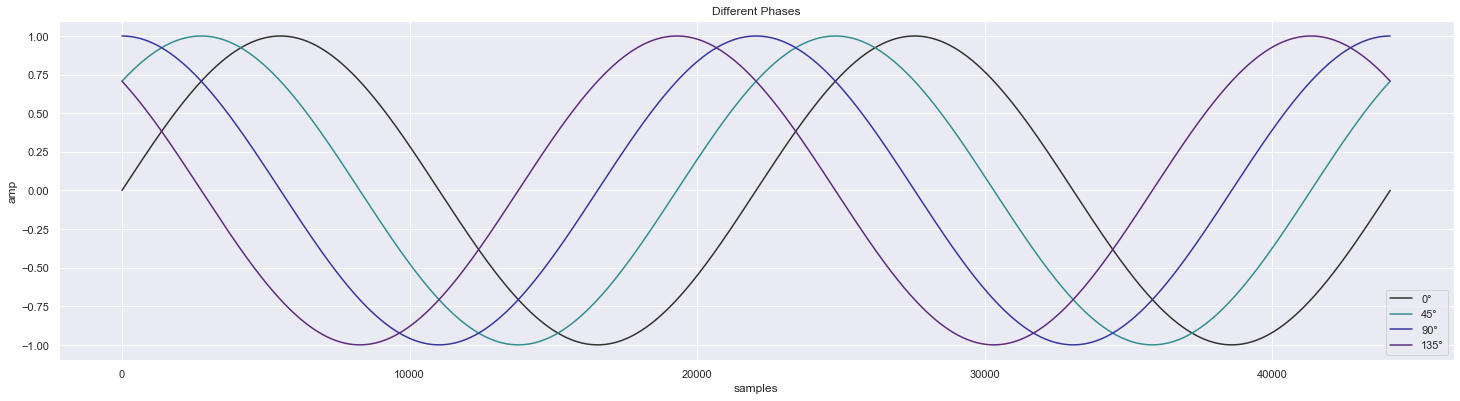

In [15]:
# List comprehension to generate 512 samples.
fig = plt.figure(figsize=figsize)
plt.title("Different Phases")

for phase,c in zip([0, 45, 90, 135],colors):
    osc = get_sin_oscillator(freq=2, sample_rate=SR, phase=phase); 
    wave = get_n(osc, SR)
    plt.plot(wave, label=f"{phase}°", color=c)

plt.ylabel("amp")
plt.xlabel("samples")
plt.legend(loc='lower right')
plt.show()
fig.savefig("sine_phase.jpg")

## Oscillators - An OOP journey

In [16]:
from abc import ABC, abstractmethod

class Oscillator(ABC):
    def __init__(self, freq=440, phase=0, amp=1, \
                 sample_rate=44_100, wave_range=(-1, 1)):
        self._freq = freq
        self._amp = amp
        self._phase = phase
        self._sample_rate = sample_rate
        self._wave_range = wave_range
        
        # Properties that will be changed
        self._f = freq
        self._a = amp
        self._p = phase
        
    @property
    def init_freq(self):
        return self._freq
    
    @property
    def init_amp(self):
        return self._amp
    
    @property
    def init_phase(self):
        return self._phase
    
    @property
    def freq(self):
        return self._f
    
    @freq.setter
    def freq(self, value):
        self._f = value
        self._post_freq_set()
        
    @property
    def amp(self):
        return self._a
    
    @amp.setter
    def amp(self, value):
        self._a = value
        self._post_amp_set()
        
    @property
    def phase(self):
        return self._p
    
    @phase.setter
    def phase(self, value):
        self._p = value
        self._post_phase_set()
    
    def _post_freq_set(self):
        pass
    
    def _post_amp_set(self):
        pass
    
    def _post_phase_set(self):
        pass
    
    @abstractmethod
    def _initialize_osc(self):
        pass
    
    @staticmethod
    def squish_val(val, min_val=0, max_val=1):
        return (((val + 1) / 2 ) * (max_val - min_val)) + min_val
    
    @abstractmethod
    def __next__(self):
        return None
    
    def __iter__(self):
        self.freq = self._freq
        self.phase = self._phase
        self.amp = self._amp
        self._initialize_osc()
        return self

### Sine wave, revisited

In [17]:
# import wave
from scipy.io import wavfile

def get_val(osc, sample_rate=SR):
    return [next(osc) for i in range(sample_rate)]

def plot_osc(Osc, name=""):
    fig = plt.figure(figsize=figsize)

    f = 8
    plt.title(f"{f}Hz {name} Wave")
    for a,p,c in zip([1.0,0.9,0.8,0.7],[0,15,30,45],colors):
        osc = Osc(freq=f,amp=a,phase=p); iter(osc)
        plt.plot(get_val(osc), color=c, label=f"amp:{a}, phase:{p:02}°")

    plt.legend(loc='lower right')
    fig.savefig(f"{name.lower()}_all.jpg")

def get_seq(osc, notes=["C4", "E4", "G4"], note_lens=[0.5,0.5,0.5]):
    samples = []
    osc = iter(osc)
    for note, note_len in zip(notes, note_lens):
        osc.freq = librosa.note_to_hz(note)
        for _ in range(int(SR * note_len)):
            samples.append(next(osc))
    return samples

to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))
def wave_to_file(wav, wav2=None, fname="temp.wav", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(fname, SR, wav)

In [18]:
class SineOscillator(Oscillator):
    def _post_freq_set(self):
        self._step = (2 * math.pi * self._f) / self._sample_rate
        
    def _post_phase_set(self):
        self._p = (self._p / 360) * 2 * math.pi
        
    def _initialize_osc(self):
        self._i = 0
        
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Dan\AppData\Local\Temp\ipykernel_4276\1144164654.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


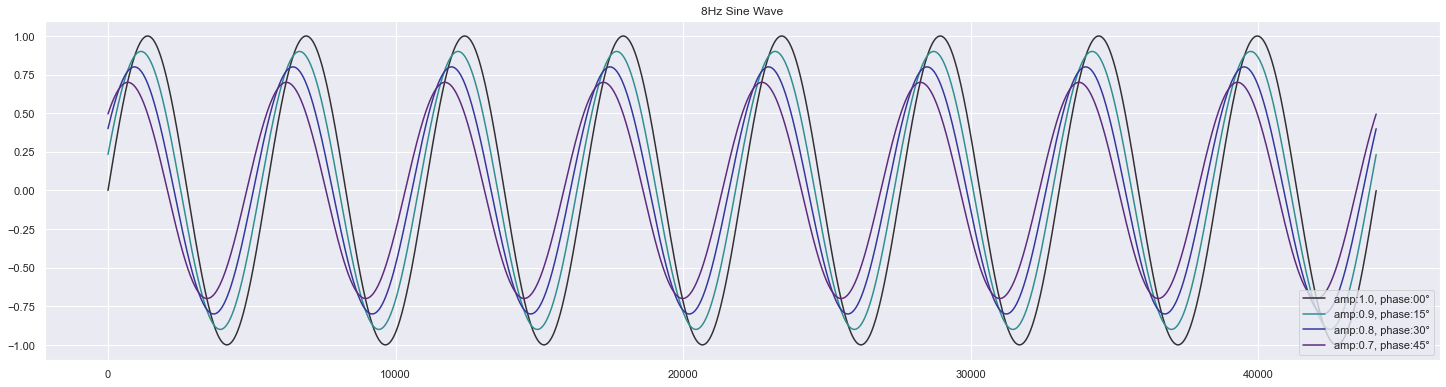

In [19]:
plot_osc(SineOscillator, "Sine")

In [20]:
osc = SineOscillator()
wav = get_seq(osc)
wave_to_file(wav, fname="c4_maj_sine.wav")

## Beyond Sine

In [21]:
class SquareOscillator(SineOscillator):
    def __init__(self, freq=440, phase=0, amp=1, \
                 sample_rate=44_100, wave_range=(-1, 1), threshold=0):
        super().__init__(freq, phase, amp, sample_rate, wave_range)
        self.threshold = threshold
    
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if val < self.threshold:
            val = self._wave_range[0]
        else:
            val = self._wave_range[1]
        return val * self._a

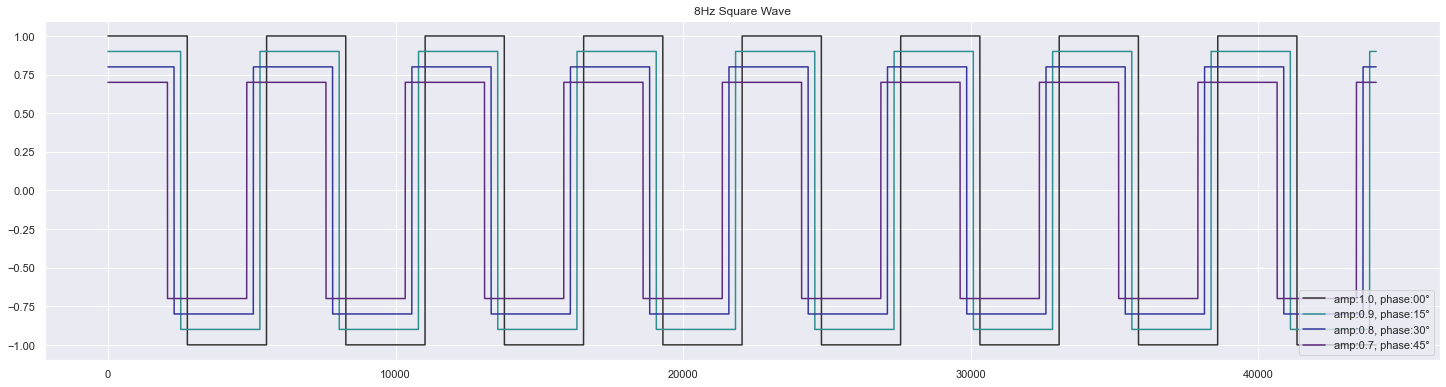

In [22]:
plot_osc(SquareOscillator, "Square")

In [23]:
osc = SquareOscillator()
wav = get_seq(osc)
wave_to_file(wav, fname="c4_maj_square.wav")

In [24]:
class SawtoothOscillator(Oscillator):
    def _post_freq_set(self):
        self._period = self._sample_rate / self._f
        self._post_phase_set
        
    def _post_phase_set(self):
        self._p = ((self._p + 90)/ 360) * self._period
    
    def _initialize_osc(self):
        self._i = 0
    
    def __next__(self):
        div = (self._i + self._p )/self._period
        val = 2 * (div - math.floor(0.5 + div))
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Dan\AppData\Local\Temp\ipykernel_4276\332260643.py:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


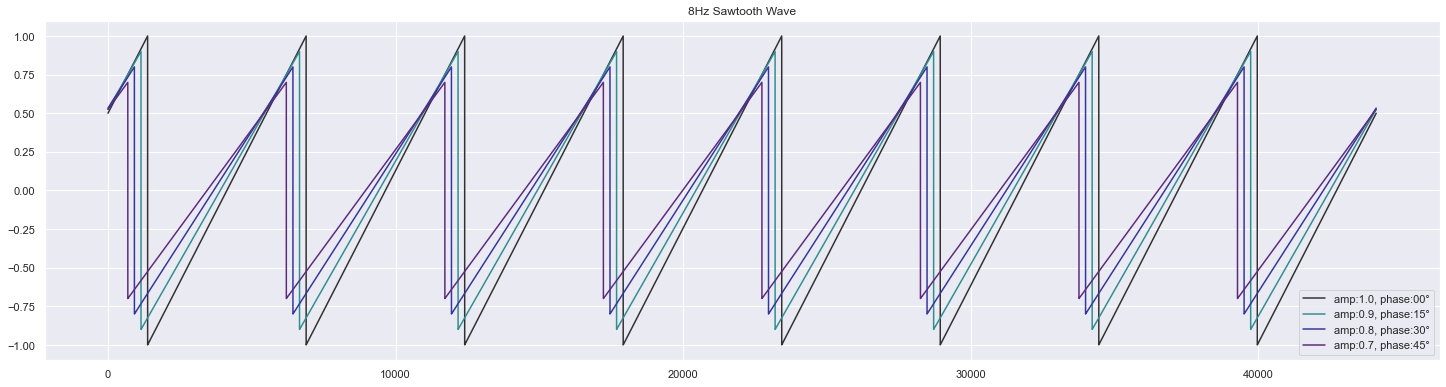

In [25]:
plot_osc(SawtoothOscillator, "Sawtooth")

In [26]:
osc = SawtoothOscillator()
wav = get_seq(osc)
wave_to_file(wav, fname="c4_maj_saw.wav")

In [27]:
class TriangleOscillator(SawtoothOscillator):
    def __next__(self):
        div = (self._i + self._p)/self._period
        val = 2 * (div - math.floor(0.5 + div))
        val = (abs(val) - 0.5) * 2
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Dan\AppData\Local\Temp\ipykernel_4276\29090328.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


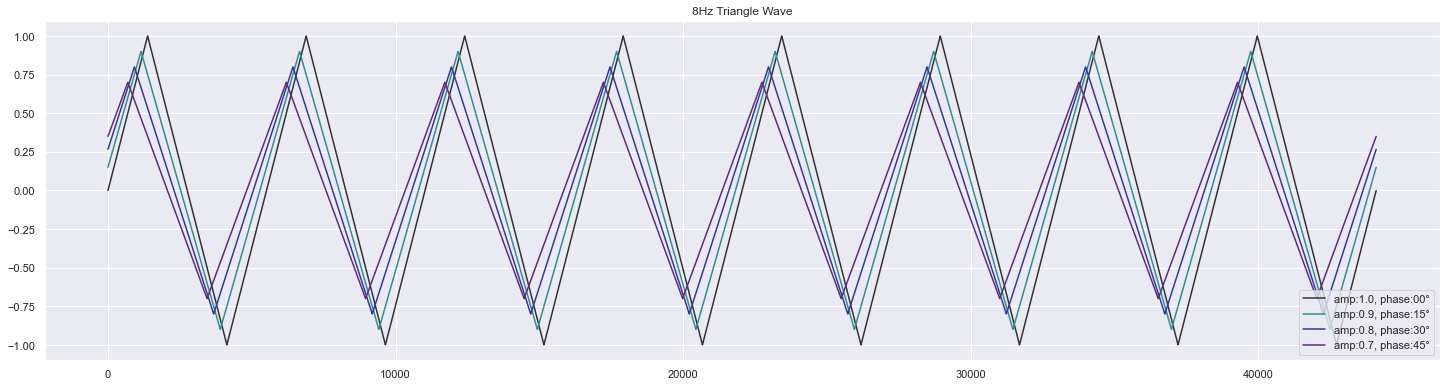

In [28]:
plot_osc(TriangleOscillator, "Triangle")

In [29]:
osc = TriangleOscillator()
wav = get_seq(osc)
wave_to_file(wav, fname="c4_maj_triangle.wav")

## Seeing the waves differently

In [30]:
def fplot_xy(wave, fslice=slice(0,100), sample_rate=SR):
    fd = np.fft.fft(wave)
    fd_mag = np.abs(fd)
    x = np.linspace(0, sample_rate, len(wave))
    y = fd_mag * 2 / sample_rate
    return x[fslice], y[fslice]

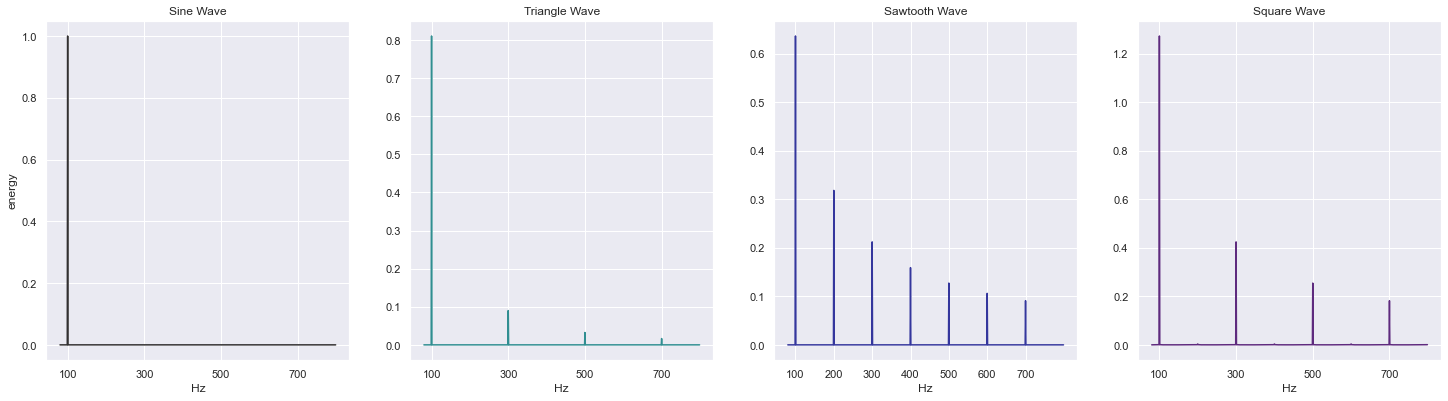

In [31]:
freq = 100; fslice = slice(80,800)
fig = plt.figure(figsize=figsize)

osc = SineOscillator(freq=freq)
x,y = fplot_xy(get_val(iter(osc)), fslice)
plot((x,y), 1,4,1,"Sine Wave", "Hz", "energy", color=colors[0], xticks=[100,300,500,700])

osc = TriangleOscillator(freq=freq)
x,y = fplot_xy(get_val(iter(osc)), fslice)
plot((x,y), 1,4,2, "Triangle Wave", "Hz", color=colors[1], xticks=[100,300,500,700])

osc = SawtoothOscillator(freq=freq)
x,y = fplot_xy(get_val(iter(osc)), fslice)
plot((x,y), 1,4,3, "Sawtooth Wave", "Hz", color=colors[2], xticks=[100,200,300,400,500,600,700])

osc = SquareOscillator(freq=freq)
x,y = fplot_xy(get_val(iter(osc)), fslice)
plot((x,y), 1,4,4, "Square Wave", "Hz", color=colors[3], xticks=[100,300,500,700])
fig.savefig("freq_dom.jpg")

## Adding waveforms

In [32]:
class WaveAdder:
    def __init__(self, *oscillators):
        self.oscillators = oscillators
        self.n = len(oscillators)
    
    def __iter__(self):
        [iter(osc) for osc in self.oscillators]
        return self
    
    def __next__(self):
        return sum(next(osc) for osc in self.oscillators) / self.n

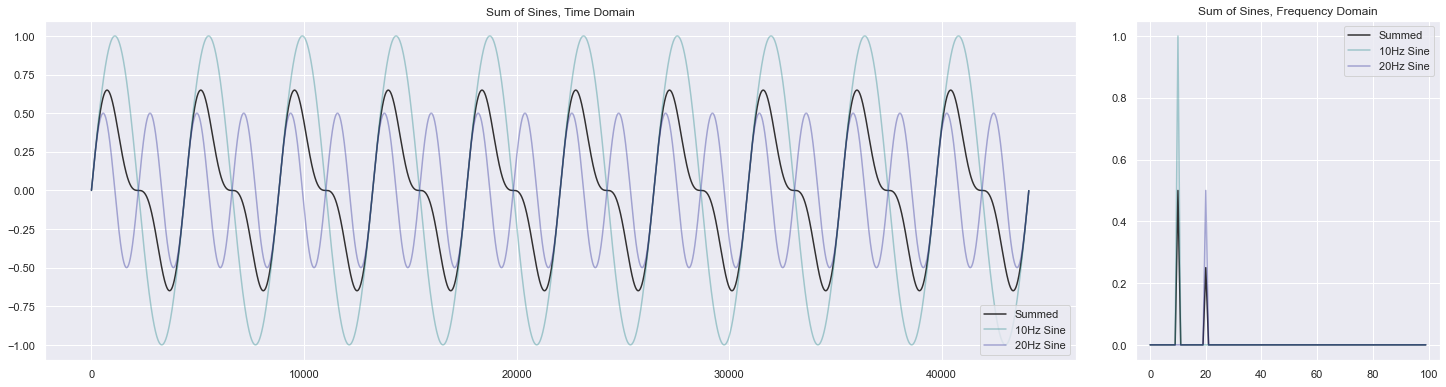

In [33]:
fig = plt.figure(figsize=figsize)
fslice=slice(0,100)

plt.subplot2grid((1,4),(0,0),colspan=3)
plt.title("Sum of Sines, Time Domain")
osc = WaveAdder(SineOscillator(10), SineOscillator(20, amp=0.5))
wave = get_val(iter(osc))
xs,ys = fplot_xy(wave, fslice)

plt.plot(wave, color=colors[0], label="Summed")

osc = SineOscillator(10, amp=1)
wave = get_val(iter(osc))
x1,y1 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.4, color=colors[1], label="10Hz Sine")

osc = SineOscillator(20, amp=0.5)
wave = get_val(iter(osc))
x2,y2 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.4, color=colors[2], label="20Hz Sine")
plt.legend(loc="lower right")

plt.subplot2grid((1,4),(0,3))
plt.title("Sum of Sines, Frequency Domain")
plt.plot(xs,ys, label="Summed", color=colors[0])
plt.plot(x1,y1, label="10Hz Sine", alpha=0.4, color=colors[1])
plt.plot(x2,y2, label="20Hz Sine", alpha=0.4, color=colors[2])


plt.legend(loc="upper right")
plt.savefig("sine_sum.jpg")

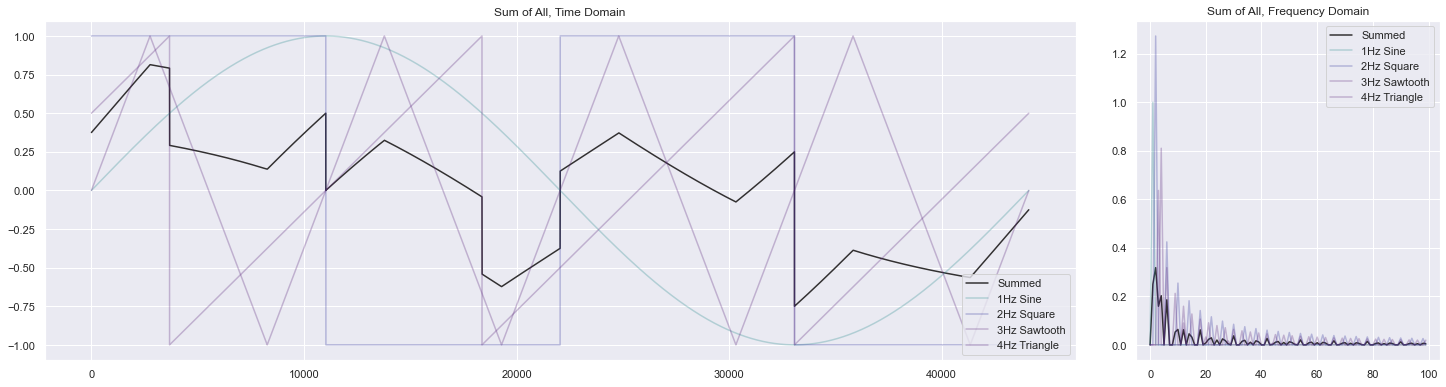

In [34]:
fig = plt.figure(figsize=figsize)
fslice=slice(0,100)

plt.subplot2grid((1,4),(0,0),colspan=3)
plt.title("Sum of All, Time Domain")
f = [1,2,3,4]
osc = WaveAdder(SineOscillator(f[0]), 
                SquareOscillator(f[1]), 
                SawtoothOscillator(f[2]), 
                TriangleOscillator(f[3])
               )
wave = get_val(iter(osc))
xs,ys = fplot_xy(wave, fslice)

plt.plot(wave, color=colors[0], label="Summed")

wave = get_val(iter(osc.oscillators[0]))
x1,y1 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.3, color=colors[1], label=f"{f[0]}Hz Sine")

wave = get_val(iter(osc.oscillators[1]))
x2,y2 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.3, color=colors[2], label=f"{f[1]}Hz Square")

wave = get_val(iter(osc.oscillators[2]))
x3,y3 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.3, color=colors[3], label=f"{f[2]}Hz Sawtooth")

wave = get_val(iter(osc.oscillators[3]))
x4,y4 = fplot_xy(wave, fslice)
plt.plot(wave, alpha=0.3, color=colors[4], label=f"{f[3]}Hz Triangle")
plt.legend(loc="lower right")

plt.subplot2grid((1,4),(0,3))
plt.title("Sum of All, Frequency Domain")
plt.plot(xs,ys, label="Summed", color=colors[0])
plt.plot(x1,y1, label=f"{f[0]}Hz Sine", alpha=0.3, color=colors[1])
plt.plot(x2,y2, label=f"{f[1]}Hz Square", alpha=0.3, color=colors[2])
plt.plot(x3,y3, label=f"{f[2]}Hz Sawtooth", alpha=0.3, color=colors[3])
plt.plot(x4,y4, label=f"{f[3]}Hz Triangle", alpha=0.3, color=colors[4])


plt.legend(loc="upper right")
plt.savefig("all_sum.jpg")

**OT Vibes**

In [35]:
dur = 10
osc = WaveAdder(
    SquareOscillator(27.5, amp=0.1),
    TriangleOscillator(55, amp=0.5),
    SineOscillator(110),
    SquareOscillator(220, amp=0.1),
    SineOscillator(440,amp=0.3),
    TriangleOscillator(880,amp=0.05),
)
wav = get_val(iter(osc), 44100 * dur)

osc2 = WaveAdder(
    SquareOscillator(27.5, amp=0.1),
    TriangleOscillator(55, amp=0.5),
    SineOscillator(115),
    SquareOscillator(220, amp=0.1),
    SineOscillator(440,amp=0.3),
    TriangleOscillator(880,amp=0.05),
)
wav2 = get_val(iter(osc2), 44100 * dur)


wave_to_file(wav, wav2, fname="ot_vibes.wav")

**A Min 6**

In [36]:
dur = 10
osc = WaveAdder(
    SineOscillator(librosa.note_to_hz("A2")),
    SineOscillator(librosa.note_to_hz("A2")+3),
    TriangleOscillator(librosa.note_to_hz("A4"),amp=0.6),
    TriangleOscillator(librosa.note_to_hz("E5"),amp=0.8),
)
wav = get_val(iter(osc), 44100 * dur)

osc2 = WaveAdder(
    SineOscillator(librosa.note_to_hz("A2")),
    SineOscillator(librosa.note_to_hz("A2")+3),
    TriangleOscillator(librosa.note_to_hz("C5"),amp=0.8),
    TriangleOscillator(librosa.note_to_hz("F5"),amp=0.6),
)
wav2 = get_val(iter(osc2), 44100 * dur)


wave_to_file(wav, wav2, fname="a_min6.wav")

**C Maj 7**

In [37]:
dur = 10
s1 = ["C4", "E4", "G4", "B4"] * dur
l1 = [0.25, 0.25, 0.25, 0.25] * dur

s2 = ["C3", "E3", "G3"] * dur
l2 = [0.333334,0.333334, 0.333334] * dur

s3 = ["C2", "G2"] * dur
l3 = [0.5,0.5] * dur

wavl = np.array(get_seq(TriangleOscillator(amp=0.8), notes=s1, note_lens=l1)) + \
    np.array(get_seq(SineOscillator(), notes=s2, note_lens=l2)) + \
    np.array(get_seq(TriangleOscillator(amp=0.4), notes=s3, note_lens=l3))

wavr = np.array(get_seq(TriangleOscillator(amp=0.8), notes=s1[::-1], note_lens=l1)) + \
    np.array(get_seq(SineOscillator(), notes=s2[::-1], note_lens=l2)) + \
    np.array(get_seq(TriangleOscillator(amp=0.4), notes=s3[::-1], note_lens=l3))

wave_to_file(wavl, wavr, fname="c_maj7.wav")